### Import necessary libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import randint, uniform
import seaborn as sns

### Load the dataset

In [42]:

url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
housing_data = pd.read_csv(url)

In [43]:
# Create a copy of the dataset
housing = housing_data.copy()

### Scatter plot of longitude and latitude colored by median house value

In [44]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=housing ["longitude"], y=housing ["latitude"], hue=housing ["median_house_value"], 
                palette="viridis", alpha=0.7, s=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Median House Value")
plt.show()

### Geographic Heatmap

In [46]:
! pip install folium

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 100 kB 7.7 MB/s            
     |████████████████████████████████| 83 kB 6.4 MB/s              


In [48]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Sample data: Replac

# Create a map centered on the mean latitude and longitude of the data
map_center = [housing_data["latitude"].mean(), housing_data["longitude"].mean()]
map_plot = folium.Map(location=map_center, zoom_start=6)

# Add a heatmap layer to the map
folium.plugins.HeatMap(
    data=housing_data[["latitude", "longitude", "median_house_value"]].values,
    radius=10,
    max_zoom=13,
    name="Median House Value Heatmap"
).add_to(map_plot)

# Display the map
map_plot

### Parallel Coordinates Plot

In [49]:
from pandas.plotting import parallel_coordinates

# Select a subset of features for visualization
features_to_plot = ["median_income", "total_rooms", "housing_median_age", "population", "median_house_value"]

# Create a parallel coordinates plot
plt.figure(figsize=(10, 6))
parallel_coordinates(housing_data[features_to_plot], "median_house_value", colormap="viridis")
plt.title("Parallel Coordinates Plot")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

### Create income categories

In [23]:

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

### Box plot of median house value by ocean proximity

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=housing_data["ocean_proximity"], y=housing_data["median_house_value"], palette="Set3")
plt.xlabel("Ocean Proximity")
plt.ylabel("Median House Value")
plt.title("Median House Value by Ocean Proximity")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_59458/2862421231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=housing_data["ocean_proximity"], y=housing_data["median_house_value"], palette="Set3")


### Perform stratified split using StratifiedShuffleSplit

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [26]:
# Drop the income category column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Visualization of Target Variable

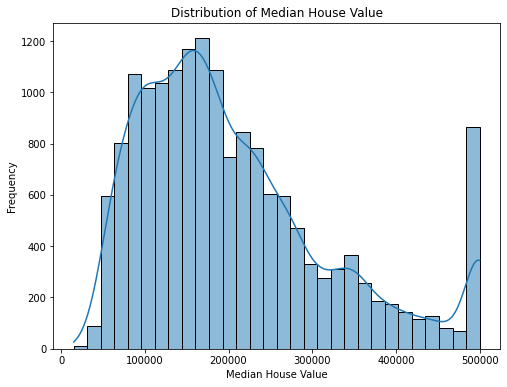

In [51]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

plt.figure(figsize=(8, 6))
sns.histplot(housing_labels, bins=30, kde=True)
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.title("Distribution of Median House Value")
plt.show()

### Correlation of variables

<Axes: >

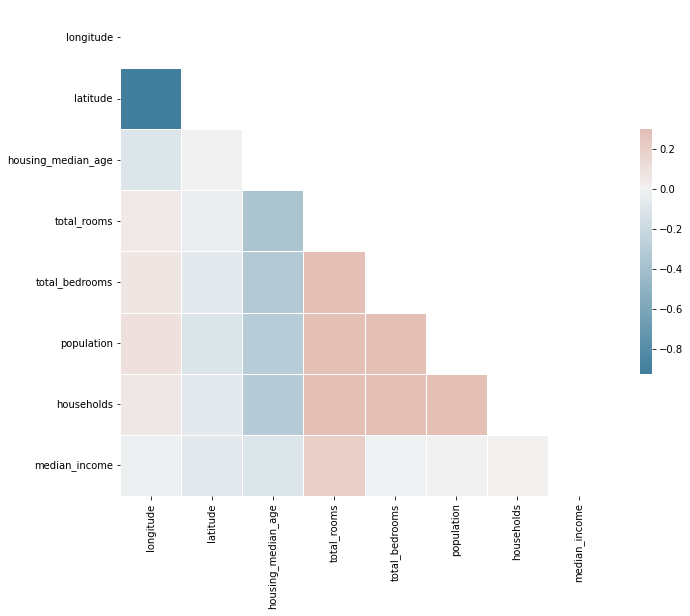

In [56]:
import seaborn as sns
numeric_cols = housing.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
f, ax = plt.subplots(figsize = (11,9))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
sns.heatmap(corr_matrix, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
            square = True, linewidth = 0.5, cbar_kws = {'shrink': 0.5})

### Custom transformers

In [29]:
# Custom transformer for adding features
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, 3] / X[:, 6]
        population_per_household = X[:, 5] / X[:, 6]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, 4] / X[:, 3]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [30]:
# Custom transformer for applying log transformation
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_index):
        self.column_index = column_index

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[:, self.column_index] = np.log1p(X[:, self.column_index])
        return X

In [31]:
# Custom transformer for applying square root transformation
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_index):
        self.column_index = column_index

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[:, self.column_index] = np.sqrt(X[:, self.column_index])
        return X

In [32]:
# Custom transformer for clustering-based feature
class ClusteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)

    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        cluster_labels = self.kmeans.predict(X)
        return np.c_[X, cluster_labels]

### Preprocessing and Feature Engineering

In [33]:
# Feature scaling and preprocessing
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('log_transformer', LogTransformer(column_index=7)),  # Median income
    ('sqrt_transformer', SqrtTransformer(column_index=5)),  # Population
    ('clustering', ClusteringTransformer()),
    ('std_scaler', StandardScaler()),
])

housing_num = housing.select_dtypes(include=[np.number])
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, list(housing_num)),
    ("cat", OneHotEncoder(), cat_attribs),
])

### Apply the transformations

In [34]:
housing_prepared = full_pipeline.fit_transform(housing)

### Train and evaluate different models with hyperparameter tuning and regularization

In [35]:
models = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Ridge', Ridge(random_state=42)),
    ('Lasso', Lasso(random_state=42)),
    ('Elastic Net', ElasticNet(random_state=42)),
    ('SVR', SVR())
]

### Hyperparameter tuning and regularization using RandomizedSearchCV

In [36]:
param_distributions = {
    'Random Forest': {
        'n_estimators': randint(50, 300),
        'max_features': randint(2, 10),
        'max_depth': randint(5, 30),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    },
    'Gradient Boosting': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'subsample': uniform(0.5, 1.0),
        'alpha': [0.1, 0.5, 1.0]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'Lasso': {
        'alpha': [0.1, 1.0, 10.0],
        'selection': ['cyclic', 'random']
    },
    'Elastic Net': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': uniform(0.1, 0.9),
        'selection': ['cyclic', 'random']
    },
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1.0, 10.0],
        'epsilon': [0.01, 0.1, 1.0],
        'gamma': ['scale', 'auto'] + list(uniform(0.01, 0.1).rvs(3))
    }
}

best_model = None
best_rmse = float('inf')

In [37]:
for model_name, model in models:
    print(f"Training {model_name}:")
    
    param_dist = param_distributions[model_name]
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(housing_prepared, housing_labels)
    
    best_params = random_search.best_params_
    best_model_rmse = np.sqrt(-random_search.best_score_)
    
    print(f"Best parameters: {best_params}")
    print(f"Best RMSE: {best_model_rmse}")
    
    if best_model_rmse < best_rmse:
        best_rmse = best_model_rmse
        best_model = random_search.best_estimator_

print(f"\nBest model: {best_model}")
print(f"Best RMSE: {best_rmse}")

Training Random Forest:
Best parameters: {'max_depth': 29, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 299}
Best RMSE: 49314.189714778826
Training Gradient Boosting:


/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
185 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_co

Best parameters: {'alpha': 0.5, 'learning_rate': 0.11974675787331722, 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 238, 'subsample': 0.7242693094605598}
Best RMSE: 47002.2708487808
Training Ridge:


/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Best parameters: {'solver': 'sparse_cg', 'alpha': 10.0}
Best RMSE: 71573.15991075733
Training Lasso:


/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+12, tolerance: 1.772e+10
  model = cd_fast.enet_coordinate_descent(
/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.545e+12, tolerance: 1.773e+10
  model = cd_fast.enet_coordinate_descent(
/home/jupyter-

Best parameters: {'selection': 'random', 'alpha': 0.1}
Best RMSE: 71573.15578742567
Training Elastic Net:
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.9745408858501934, 'selection': 'cyclic'}
Best RMSE: 71565.5574818783
Training SVR:
Best parameters: {'kernel': 'linear', 'gamma': 0.05128915803038652, 'epsilon': 1.0, 'C': 10.0}
Best RMSE: 87930.47803336088

Best model: GradientBoostingRegressor(alpha=0.5, learning_rate=0.11974675787331722,
                          max_depth=8, min_samples_leaf=3, min_samples_split=9,
                          n_estimators=238, random_state=42,
                          subsample=0.7242693094605598)
Best RMSE: 47002.2708487808


### Evaluation on Test set

In [38]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = best_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"Final RMSE on test set: {final_rmse}")

Final RMSE on test set: 44478.482845801496


### Bar plot of RMSE scores for different models

In [39]:
model_names = [model[0] for model in models]
best_rmse_scores = []
for model_name, model in models:
    param_dist = param_distributions[model_name]
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(housing_prepared, housing_labels)
    best_rmse_scores.append(np.sqrt(-random_search.best_score_))

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=best_rmse_scores, palette="rocket")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Scores for Different Models")
plt.xticks(rotation=45)
plt.show()

/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
185 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/jupyter-dpemmasa/.local/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_co

### Scatter plot of actual vs. predicted values

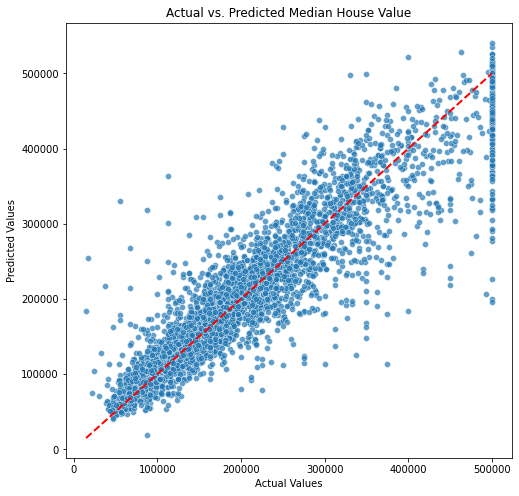

In [40]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=final_predictions, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Median House Value")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()